#PAMPA Permeability, NCATS
## Binary Classification via classical Machine Learning (ML) algorithms
Based on the SMILES string of a compound, using classical ML algorithms, this tutorial explains how to predict whether it will have high permeability (1) or low-to-moderate permeability (0) in the PAMPA assay. 

**Dataset Description:** PAMPA (parallel artificial membrane permeability assay) is a commonly employed assay to evaluate drug permeability across the cellular membrane. PAMPA is a non-cell-based, low-cost and high-throughput alternative to cellular models. Although PAMPA does not model active and efflux transporters, it still provides permeability values that are useful for absorption prediction because the majority of drugs are absorbed by passive diffusion through the membrane. 

**References:**
[1] Siramshetty, V.B., Shah, P., et al. “Validating ADME QSAR Models Using Marketed Drugs.” SLAS Discovery 2021 Dec;26(10):1326-1336. doi: 10.1177/24725552211017520.

**Dataset License:** Not Specified. CC BY 4.0.

**Dataset Statistics:** NCATS set - 2035 compounds; Approved drugs set - 142 drugs. 

###**This tutorial includes four steps:**
**Step 1:** To determine the permeability of a PAMPA compound, six basic machine learning algorithms are evaluated in the first step. Following the selection of the best algorithm, the parameters are tuned and the final performance of the model is evaluated. The six algorithms selected include:
* **Linear Algorithms:** Logistic Regression (LR) and Linear Discriminant Analysis (LDA).

* **Nonlinear Algorithms:** Classification and Regression Trees (CART), Support Vector Machines (SVM), Gaussian Naive Bayes (NB), and k-Nearest Neighbors (KNN).

**Step2:** In the second step, the problem model is re-modeled using supervised ensemble learning models, including classical trees, and its performance is evaluated based on five prominent algorithms. The best model is tuned in this stage and the final performance of the model is evaluated.
In this section we will evaluate five different ensemble machine learning algorithms, three boosting and two bagging methods:

* **Boosting Methods:** AdaBoost (AB) and Gradient Boosting (GBM), XGBoost (XGB).

* **Bagging Methods:** Random Forests (RF) and Extra Trees (ET).

**Step 3:** In the third step, the performance of the best models from the first and second phases is compared and the best model is selected.

**Step 4:** Based on the best algorithm selected from previous steps and using the entire dataset, the modeling and tuning of the problem are performed. 

**Note:** All the first three steps are implemented based on the 10% of the dataset.

**Note:** This tutorial has been designed for running on Colab + GPU.

## Install packages and libraries

In [ ]:
!pip install PyTDC
!pip install --pre deepchem
!pip install DeepPurpose
!pip install PubChemPy
!pip install git+https://github.com/samoturk/mol2vec
!pip install 'mordred[full]' 

# !pip install tensorflow==2.4
# !pip install gensim==3.8
# !pip install numpy==1.20

## Imports

In [2]:
import sys
import deepchem
from mol2vec import features
from mol2vec import helpers
import mordred
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import [dataset](https://tdcommons.ai/single_pred_tasks/adme/#pampa-permeability-ncats)

In [3]:
# import dataset
from tdc.single_pred import ADME
data = ADME(name = 'PAMPA_NCATS')
split = data.get_split()

Downloading...
100%|██████████| 144k/144k [00:00<00:00, 338kiB/s] 
Loading...
Done!


Determine the shape of Train, Val, Test split

In [4]:
print(f'train shape: ', split['train'].shape)
print(f'validation shape: ', split['valid'].shape)
print(f'test shape: ', split['test'].shape)

train shape:  (1424, 3)
validation shape:  (203, 3)
test shape:  (407, 3)


Creating input and target variables for each train, validation, and test dataset.

In [5]:
train = split['train']
valid = split['valid']
test = split['test']

#====================================
X_train = train['Drug'].to_list()
y_train = train['Y'].to_list()

X_valid = valid['Drug'].to_list()
y_valid = valid['Y'].to_list()

X_test = test['Drug'].to_list()
y_test = test['Y'].to_list()

#====================================
print(f"X_train: ", X_train[0:3])
print(f"y_train: ", y_train[0:3])

X_train:  ['COC1=C(C=C(C=C1)CCN2C(=CC(=O)NC2=S)N)OC', 'COC1=C(C=C(C=C1)Cl)C(=O)NC2=CC=C(C=C2)NC(=O)C3=CC=CO3', 'CN1C2=CC=CC=C2C(=O)C3=C1N=C(N(C3=O)C4=CC=CC=C4)C5CCCCC5']
y_train:  [0, 1, 1]


In [6]:
train.head()

,Drug_ID,Drug,Y
0,1259573,COC1=C(C=C(C=C1)CCN2C(=CC(=O)NC2=S)N)OC,0
1,1275864,COC1=C(C=C(C=C1)Cl)C(=O)NC2=CC=C(C=C2)NC(=O)C3...,1
2,2030130,CN1C2=CC=CC=C2C(=O)C3=C1N=C(N(C3=O)C4=CC=CC=C4...,1
3,4422695,CC1=C(C=C(C=C1)NS(=O)(=O)C2=CC=CC(=C2)C(=O)O)S...,1
4,1131802,COC1=CC(=CC(=C1O)OC)C2=NC(=C(N2)C3=CC=CS3)C4=C...,1


## Data preprocessing: 
The following part will involve the transformation of our dataset from the form of SMILES string compounds to binary form using different **featurizers** from the **DeepChem** library. This library provides some of the main features that are used in the field of drug discovery (biology, chemistry, etc.).

Featurizer = *A “featurizer” is chunk of code which transforms raw input data into a processed form suitable for machine learning.*



Mol2vec and Morded featureizers are inactive due to some dependencies not being met.There are some conflicts between the libraries they use.

In [7]:
# featurize
maccskeys = deepchem.feat.MACCSKeysFingerprint()
circular = deepchem.feat.CircularFingerprint()
# mol2vec = deepchem.feat.Mol2VecFingerprint()
# mordred = deepchem.feat.MordredDescriptors(ignore_3D=True)
rdkit = deepchem.feat.RDKitDescriptors()
pubchem = deepchem.feat.PubChemFingerprint()

Mapping featurizers to the dataset. 

In [ ]:
maccskeys_train = maccskeys.featurize(X_train)
maccskeys_valid = maccskeys.featurize(X_valid)
maccskeys_test = maccskeys.featurize(X_test)

circular_train = circular.featurize(X_train)
circular_valid = circular.featurize(X_valid)
circular_test = circular.featurize(X_test)

# mol2vec_train = mol2vec.featurize(X_train)
# mol2vec_valid = mol2vec.featurize(X_valid)
# mol2vec_test = mol2vec.featurize(X_test)

# mordred_train = mordred.featurize(X_train)
# mordred_valid = mordred.featurize(X_valid)
# mordred_test = mordred.featurize(X_test)

rdkit_train = rdkit.featurize(X_train)
rdkit_valid = rdkit.featurize(X_valid)
rdkit_test = rdkit.featurize(X_test)

pubchem_train = pubchem.featurize(X_train)
pubchem_valid = pubchem.featurize(X_valid)
pubchem_test = pubchem.featurize(X_test)

Eliminating empty lists

In [ ]:
# process pubchem empty lists
pubchem_train_tmp = []
for i in range(len(pubchem_train)):
    if len(pubchem_train[i]) == 0:
        pubchem_train = np.array([0] * 881)
    pubchem_train_tmp.append(pubchem_train[i].tolist())

pubchem_train = np.array(pubchem_train_tmp)

pubchem_valid_tmp = []
for i in range(len(pubchem_valid)):
    if len(pubchem_valid[i]) == 0:
        pubchem_valid[i] = np.array([0] * 881)
    pubchem_valid_tmp.append(pubchem_valid[i].tolist())

pubchem_valid = np.array(pubchem_valid_tmp)

pubchem_test_tmp = []
for i in range(len(pubchem_test)):
    if len(pubchem_test[i]) == 0:
        pubchem_test[i] = np.array([0] * 881)
    pubchem_test_tmp.append(pubchem_test[i].tolist())

pubchem_test = np.array(pubchem_test_tmp)

Combining features into the single files: `fp_train`, `fp_valid`, `fp_test`


In [ ]:
# combine features
fp_train = np.concatenate(
    (
        maccskeys_train, circular_train, rdkit_train, pubchem_train #, mordred_train,mol2vec_train,
    ), axis=1
)

fp_valid = np.concatenate(
    (
        maccskeys_valid, circular_valid, rdkit_valid, pubchem_valid #, mordred_test,mol2vec_test,
    ), axis=1
)

fp_test = np.concatenate(
    (
        maccskeys_test, circular_test, rdkit_test, pubchem_test #, mordred_test,mol2vec_test,
    ), axis=1
)

Converting `nan` to `0`

In [ ]:
# convert nan to 0
fp_train = np.nan_to_num(fp_train, nan=0, posinf=0)
fp_valid = np.nan_to_num(fp_valid, nan=0, posinf=0)
fp_test = np.nan_to_num(fp_test, nan=0, posinf=0)

Determine the shape of the input and target variables in the `train, Val, test` dataset.

In [ ]:
print(f"X_train shape: ", fp_train.shape)
print(f"y_train shape: ", np.shape(y_train))

print(f"X_valid shape: ", fp_valid.shape)
print(f"y_valid shape: ", np.shape(y_valid))

print(f"X_test shape: ", fp_test.shape)
print(f"y_test shape: ", np.shape(y_test))

X_train shape:  (1424, 3304)
y_train shape:  (1424,)
X_valid shape:  (203, 3304)
y_valid shape:  (203,)
X_test shape:  (407, 3304)
y_test shape:  (407,)


Save the preprocessed datasets in the form of NumPy arrays. 

In [ ]:
# save to npy
np.save(open("/content/" + "PAMPA_NCATS" + "_X_train.npy", "wb"), fp_train)
np.save(open("/content/" + "PAMPA_NCATS" + "_X_valid.npy", "wb"), fp_valid)
np.save(open("/content/" + "PAMPA_NCATS" + "_X_test.npy", "wb"), fp_test)
np.save(open("/content/" + "PAMPA_NCATS" + "_y_train.npy", "wb"), y_train)
np.save(open("/content/" + "PAMPA_NCATS" + "_y_valid.npy", "wb"), y_valid)
np.save(open("/content/" + "PAMPA_NCATS" + "_y_test.npy", "wb"), y_test)

# Algorithm performance checking
**Note:** The algorithm's performance is evaluated using only **10%** of the "train" dataset in order to establish a baseline model and to create a faster evaluation process. The problem will be remodeled with the whole dataset once the best machine-learning algorithm has been selected. 

Import relevant libraries to check the algorithms' performances.


In [8]:
# Load libraries
import numpy as np
import pandas as pd
import xgboost
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
#from skopt import BayesSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, average_precision_score

Importing 10% of the train dataset

In [9]:
#use train dataset to evaluating different algorithms performances
sample_X = np.load('/content/drive/MyDrive/DeepMirror/PAMPA_NCATS_Dataset/PAMPA_NCATS_X_train.npy') #Depending on the directory, the address should be changed
sample_y = np.load('/content/drive/MyDrive/DeepMirror/PAMPA_NCATS_Dataset/PAMPA_NCATS_y_train.npy') #Depending on the directory, the address should be changed

# Create train and test splits the right way for time series data
split_size = int(0.1 * len(sample_X)) # 10% train

# Create train data splits (everything before the split)
X_sample = sample_X[:split_size]
y_sample = sample_y[:split_size]

# X, y shapes
print(f"X_sample shape: ", X_sample.shape)
print(f"y_sample shape: ", y_sample.shape)

X_sample shape:  (142, 3304)
y_sample shape:  (142,)


We will use 80% of the dataset for modeling and hold back 20% for validation.

In [10]:
# Split-out validation dataset
validation_size = 0.20
seed = 42
X_train, X_validation, Y_train, Y_validation = train_test_split(X_sample, y_sample, test_size=validation_size, random_state=seed)

##Step 1: Evaluate Classical ML Algorithms: Baseline

* **Linear Algorithms:** Logistic Regression (LR) and Linear Discriminant Analysis (LDA).

* **Nonlinear Algorithms:** Classification and Regression Trees (CART), Support Vector Machines (SVM), Gaussian Naive Bayes (NB), and k-Nearest Neighbors (KNN).

We will use **10-fold cross validation**. The dataset is not too small and this is a good standard test harness configuration. We will evaluate algorithms using the **accuracy** metric. This is a gross metric that will give a quick idea of how correct a given model is. 

In [11]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'accuracy'

In [12]:
# Spot-Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [13]:
results = []
names = []
for name, model in models:
  kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f" name: {name} , Accuracy: {cv_results.mean()*100:.3f}%, Std: {cv_results.std()}")

 name: LR , Accuracy: 63.106%, Std: 0.1282094855161214
 name: LDA , Accuracy: 69.773%, Std: 0.12468739607566022
 name: KNN , Accuracy: 71.667%, Std: 0.11892733001933582
 name: CART , Accuracy: 71.742%, Std: 0.06320652085944292
 name: NB , Accuracy: 68.030%, Std: 0.11705955098011334
 name: SVM , Accuracy: 74.167%, Std: 0.09763326462737905


Algorithm Comparison

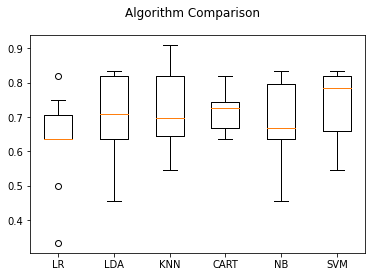

In [14]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

##Algorithm Tuning :SVM and KNN 

Based on the above chart, it can be seen that the **SVM** and **KNN** have better performance than the other algorithms. Therefore, to select the best classical ML algorithm, both SVM and KNN have been **tuned** and their performance has been evaluated.

###Tuning SVM

In [15]:
# Tune scaled SVM
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print(f"Best:{grid_result.best_score_*100:.2f}%, using  Param:{grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print(f"Accuracy:{mean*100:.2f}%, Std:{stdev}, Param:{param}")

Best:74.24%, using  Param:{'C': 1.7, 'kernel': 'sigmoid'}
Accuracy:62.12%, Std:0.12771388189628194, Param:{'C': 0.1, 'kernel': 'linear'}
Accuracy:74.17%, Std:0.09763326462737905, Param:{'C': 0.1, 'kernel': 'poly'}
Accuracy:74.17%, Std:0.09763326462737905, Param:{'C': 0.1, 'kernel': 'rbf'}
Accuracy:74.17%, Std:0.09763326462737905, Param:{'C': 0.1, 'kernel': 'sigmoid'}
Accuracy:62.12%, Std:0.12771388189628194, Param:{'C': 0.3, 'kernel': 'linear'}
Accuracy:74.17%, Std:0.09763326462737905, Param:{'C': 0.3, 'kernel': 'poly'}
Accuracy:74.17%, Std:0.09763326462737905, Param:{'C': 0.3, 'kernel': 'rbf'}
Accuracy:74.17%, Std:0.09763326462737905, Param:{'C': 0.3, 'kernel': 'sigmoid'}
Accuracy:62.12%, Std:0.12771388189628194, Param:{'C': 0.5, 'kernel': 'linear'}
Accuracy:74.17%, Std:0.09763326462737905, Param:{'C': 0.5, 'kernel': 'poly'}
Accuracy:74.17%, Std:0.09763326462737905, Param:{'C': 0.5, 'kernel': 'rbf'}
Accuracy:74.17%, Std:0.09763326462737905, Param:{'C': 0.5, 'kernel': 'sigmoid'}
Accura

###Tuning KNN

In [16]:
# Tune scaled KNN
neighbors = [1,3,5,7,9,11,13,15,17,19,21,23,25]
param_grid = dict(n_neighbors=neighbors)
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print(f"Best:{grid_result.best_score_*100:.2f}%, using  Param:{grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print(f"Accuracy:{mean*100:.2f}%, Std:{stdev}, Param:{param}")

Best:74.17%, using  Param:{'n_neighbors': 9}
Accuracy:57.58%, Std:0.11558927953188275, Param:{'n_neighbors': 1}
Accuracy:67.27%, Std:0.15948004357135304, Param:{'n_neighbors': 3}
Accuracy:71.67%, Std:0.11892733001933582, Param:{'n_neighbors': 5}
Accuracy:70.68%, Std:0.12318703630529587, Param:{'n_neighbors': 7}
Accuracy:74.17%, Std:0.09763326462737905, Param:{'n_neighbors': 9}
Accuracy:74.17%, Std:0.09763326462737905, Param:{'n_neighbors': 11}
Accuracy:74.17%, Std:0.09763326462737905, Param:{'n_neighbors': 13}
Accuracy:74.17%, Std:0.09763326462737905, Param:{'n_neighbors': 15}
Accuracy:74.17%, Std:0.09763326462737905, Param:{'n_neighbors': 17}
Accuracy:74.17%, Std:0.09763326462737905, Param:{'n_neighbors': 19}
Accuracy:74.17%, Std:0.09763326462737905, Param:{'n_neighbors': 21}
Accuracy:74.17%, Std:0.09763326462737905, Param:{'n_neighbors': 23}
Accuracy:74.17%, Std:0.09763326462737905, Param:{'n_neighbors': 25}


According to the results below, **SVM** appears to be the most appropriate classical machine learning algorithm to this problem. 
* **Tuned SVM accuracy: 74.24%**
* **Tune KNN accuracy: 74.17%**


##Step 2: Ensemble Methods
Another way that we can improve the performance of algorithms on this problem is by using ensemble methods. In this section we will evaluate five different ensemble machine learning algorithms, three boosting and two bagging methods:
* **Boosting Methods:** AdaBoost (AB) and Gradient Boosting (GBM), XGBoost (XGB).

* **Bagging Methods:** Random Forests (RF) and Extra Trees (ET).

In [17]:
# ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
ensembles.append(('XGB', XGBClassifier()))
results = []
names = []
for name, model in ensembles:
  kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f" name: {name} , Accuracy: {cv_results.mean()*100:.2f}%, Std: {cv_results.std()}")

 name: AB , Accuracy: 70.61%, Std: 0.11607484681996852
 name: GBM , Accuracy: 72.35%, Std: 0.10666763515400551
 name: RF , Accuracy: 78.56%, Std: 0.09510819801499888
 name: ET , Accuracy: 75.00%, Std: 0.10016056897599036
 name: XGB , Accuracy: 77.65%, Std: 0.0959014310694861


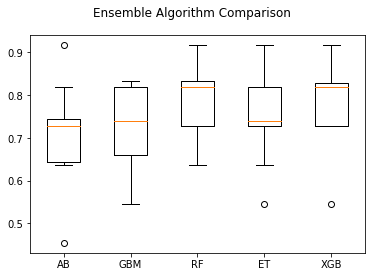

In [18]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Accordint to the above chart, it can be seen that the **XGB** and **Random Forest (RF)** have better performance than the other methods. Therefore, to select the best ensamble ML algorithm, the performance of both XGB and RF have been evaluated.

##Finalize sample Model
###Random Forest

In [19]:
#Random Forest
# prepare the model
model = RandomForestClassifier()
model.fit(X_train, Y_train)

# estimate accuracy on validation dataset
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.896551724137931
[[ 0  2]
 [ 1 26]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.93      0.96      0.95        27

    accuracy                           0.90        29
   macro avg       0.46      0.48      0.47        29
weighted avg       0.86      0.90      0.88        29



In [20]:
# XGBClassifier
# prepare the model
model = XGBClassifier()
model.fit(X_train, Y_train)

# estimate accuracy on validation dataset
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9310344827586207
[[ 1  1]
 [ 1 26]]
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.96      0.96      0.96        27

    accuracy                           0.93        29
   macro avg       0.73      0.73      0.73        29
weighted avg       0.93      0.93      0.93        29



As can be seen the performance of **XGB** is better than **RF** as bellow: 
* **RF accuracy: 89.65%**
* **XGB accuracy: 93.10%**

##Step 3: Comparing models from Step 1 and 2 
The **XGBClassifier** has been selected as the best classical tree-based ensemble machine learning algorithm for this problem after evaluating the performance of the best algorithms from steps 1 and 2. 
* **Step 1-Best algorithm: SVM accuracy: 74.24%**
* **Step 2-Best algorithm: XGB accuracy: 93.10%**


##Step 4: XGBClassifier: Whole dataset + tuning

###Tuning the model to find the best parameters for our model

In [21]:
# Load libraries
from tdc import Evaluator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, average_precision_score


#use train dataset to evaluating different algorithms performances 
X_train = np.load('/content/drive/MyDrive/DeepMirror/PAMPA_NCATS_Dataset/PAMPA_NCATS_X_train.npy') #Depending on the directory, the address should be changed
y_train = np.load('/content/drive/MyDrive/DeepMirror/PAMPA_NCATS_Dataset/PAMPA_NCATS_y_train.npy') #Depending on the directory, the address should be changed
X_validation = np.load('/content/drive/MyDrive/DeepMirror/PAMPA_NCATS_Dataset/PAMPA_NCATS_X_valid.npy') #Depending on the directory, the address should be changed
y_validation= np.load('/content/drive/MyDrive/DeepMirror/PAMPA_NCATS_Dataset/PAMPA_NCATS_y_valid.npy') #Depending on the directory, the address should be changed

# X, y shapes
print(f"X_train shape: ", X_train.shape)
print(f"y_train shape: ", y_train.shape)
print(f"X_validation shape: ", X_validation.shape)
print(f"y_validation shape: ", y_validation.shape)
print("=========================================================================")

# finetune with grid search
params = {
    "n_estimators": [50, 100, 200, 500, 1000],
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "reg_alpha": [0, 0.1, 1, 5, 10],
    "reg_lambda": [0, 0.1, 1, 5, 10],
    "min_child_weight": [1, 3, 5]
}

#model
xgb = XGBClassifier(tree_method='gpu_hist')
clf = RandomizedSearchCV(
    estimator=xgb, param_distributions=params,
    scoring='roc_auc', n_iter=100
)
clf.fit(X_train, y_train)

# print best parameters
best_params = clf.best_params_
print(best_params)

X_train shape:  (1424, 3304)
y_train shape:  (1424,)
X_validation shape:  (203, 3304)
y_validation shape:  (203,)
{'subsample': 0.8, 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.7}


###Model the problem using the best params

In [22]:
# XGBoost Classifier
from tdc import Evaluator
import numpy as np
import pandas as pd
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#use train dataset to evaluating different algorithms performances
X_train = np.load('/content/drive/MyDrive/DeepMirror/PAMPA_NCATS_Dataset/PAMPA_NCATS_X_train.npy') 
y_train = np.load('/content/drive/MyDrive/DeepMirror/PAMPA_NCATS_Dataset/PAMPA_NCATS_y_train.npy')
X_validation = np.load('/content/drive/MyDrive/DeepMirror/PAMPA_NCATS_Dataset/PAMPA_NCATS_X_valid.npy') 
y_validation= np.load('/content/drive/MyDrive/DeepMirror/PAMPA_NCATS_Dataset/PAMPA_NCATS_y_valid.npy')


# XGBClassifier
# prepare the model
model = XGBClassifier(tree_method='gpu_hist', best_params=best_params, random_state=seed)
model.fit(X_train, y_train)

# estimate accuracy on validation dataset
predictions = model.predict(X_validation)
print(f"Accuracy_score: {(accuracy_score(y_validation, predictions))*100:.2f}%")
print("============================================================")

evaluator = Evaluator(name = 'F1')
f1_score = evaluator(y_validation, predictions)
print(f"F1_score: {f1_score*100:.2f}%")
print("============================================================")

evaluator = Evaluator(name = 'ROC-AUC')
roc_auc_score = evaluator(y_validation, predictions)
print(f"ROC-AUC: {roc_auc_score:.2f}")
print("============================================================")

evaluator = Evaluator(name = 'PR-AUC')
pr_auc_score = evaluator(y_validation, predictions)
print(f"PR-AUC: {pr_auc_score:.2f}")
print("============================================================")

print("Confusion matrix:\n", confusion_matrix(y_validation, predictions))
print("============================================================")

print("Classification Report:\n", classification_report(y_validation, predictions))
print("============================================================")

# feature importance by fingerprints and descriptors
# ending 0 is added as placeholder
feature_imp_list = [model.feature_importances_]
feature_imp = []
feature_size = [167, 2048, 208, 881] #extracted from https://deepchem.readthedocs.io, based on the corresponding Featurizers lengths. 

for feature in feature_imp_list:
    feature_imp_cur = []
    running_size = 0
    for size in feature_size:
        feature_imp_cur.append(
            np.sum(feature[running_size: running_size + size])
        )
        running_size += size
    feature_imp.append(feature_imp_cur)

feature_imp_mean = np.mean(feature_imp, axis=0)

print(
    "Feature Importance:\n",
    f"maccskeys: {feature_imp_mean[0]*100:.2f}% ",
    f"circular: {feature_imp_mean[1]*100:.2f}% ",
    f"rdkit: {feature_imp_mean[2]*100:.2f}%",
    f"pubchem: {feature_imp_mean[3]*100:.2f}%"
)

Accuracy_score: 85.71%
F1_score: 92.10%
ROC-AUC: 0.57
PR-AUC: 0.86
Confusion matrix:
 [[  5  28]
 [  1 169]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.15      0.26        33
           1       0.86      0.99      0.92       170

    accuracy                           0.86       203
   macro avg       0.85      0.57      0.59       203
weighted avg       0.85      0.86      0.81       203

Feature Importance:
 maccskeys: 6.89%  circular: 24.42%  rdkit: 54.12% pubchem: 14.57%


Extracting results

In [23]:
XGBClassifier_results = {
    "F1_score": f1_score,
    "ROC-AUC" : roc_auc_score,
    "PR-AUC" : pr_auc_score
}

XGBClassifier_results

{'F1_score': 0.9209809264305178,
 'ROC-AUC': 0.5728163992869875,
 'PR-AUC': 0.857747846206573}

Save the best model

In [24]:
model.save_model('/content/' + 'PAMPA_NCATS' + '_model')